# 02. PyTorch Neural Network Classification

## What is a classification problem?

A [classification problem](https://en.wikipedia.org/wiki/Statistical_classification) involves predicting whether something is one thing or another.

For example, you might want to:

| Problem type | What is it? | Example |
| ----- | ----- | ----- |
| **Binary classification** | Target can be one of two options, e.g. yes or no | Predict whether or not someone has heart disease based on their health parameters. |
| **Multi-class classification** | Target can be one of more than two options | Decide whether a photo is of food, a person or a dog. |
| **Multi-label classification** | Target can be assigned more than one option | Predict what categories should be assigned to a Wikipedia article (e.g. mathematics, science & philosophy). |

<div align="center">
<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/02-different-classification-problems.png" alt="various different classification in machine learning such as binary classification, multiclass classification and multilabel classification" width=900/>
</div>
    
Classification, along with regression is one of the most common types of machine learning problems.

In this notebook, we're going to work through a couple of different classification problems with PyTorch.

In other words, taking a set of inputs and predicting what class those set of inputs belong to.

<div align="center">
<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" alt="a pytorch workflow flowchart" width=900/>
</div>

Except instead of trying to predict a straight line (predicting a number, also called a regression problem), we'll be working on a **classification problem**.




## 0. Architecture of a classification neural network

Before we get into writing code, let's look at the general architecture of a classification neural network.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| **Input layer shape** (`in_features`) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| **Hidden layer(s)** | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification |
| **Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| **Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit) but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) | Same as binary classification |
| **Output activation** | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch)| [Softmax](https://en.wikipedia.org/wiki/Softmax_function) ([`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) in PyTorch) |
| **Loss function** | [Binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) in PyTorch) | Cross entropy ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in PyTorch) |
| **Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (see [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for more options) | Same as binary classification |

Of course, this ingredient list of classification neural network components will vary depending on the problem you're working on.

## 1. Make classification data and get it ready

We'll use the [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) method from Scikit-Learn to generate two circles with different coloured dots.

In [8]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

Alright, now let's view the first 5 `X` and `y` values.

In [9]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


Looks like there's two `X` values per one `y` value.

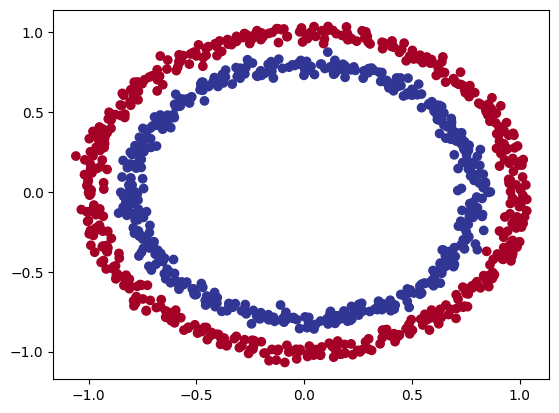

In [10]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

Alrighty, looks like we've got a problem to solve.

Let's find out how we could build a PyTorch neural network to classify dots into red (0) or blue (1).

> **Note:** This dataset is often what's considered a **toy problem** (a problem that's used to try and test things out on) in machine learning.
>
> But it represents the major key of classification, you have some kind of data represented as numerical values and you'd like to build a model that's able to classify it, in our case, separate it into red or blue dots.

### 1.1 Input and output shapes

One of the most common errors in deep learning is shape errors. Mismatching the shapes of tensors and tensor operations will result in errors in your models.

In [11]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

Looks like we've got a match on the first dimension of each.

There's 1000 `X` and 1000 `y`.

But what's the second dimension on `X`?

It often helps to view the values and shapes of a single sample (features and labels).

Doing so will help you understand what input and output shapes you'd be expecting from your model.

In [12]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


This tells us the second dimension for `X` means it has two features (vector) where as `y` has a single feature (scalar).

We have two inputs for one output.

### 1.2 Turn data into tensors and create train and test splits

We've investigated the input and output shapes of our data, now let's prepare it for being used with PyTorch and for modelling.

Specifically, we'll need to:
1. Turn our data into tensors (right now our data is in NumPy arrays and PyTorch prefers to work with PyTorch tensors).
2. Split our data into training and test sets (we'll train a model on the training set to learn the patterns between `X` and `y` and then evaluate those learned patterns on the test dataset).

In [13]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X_tensor = torch.from_numpy(X).type(torch.float)
y_tensor = torch.from_numpy(y).type(torch.float)

# View the first five samples
X_tensor[:5], y_tensor[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

Now our data is in tensor format, let's split it into training and test sets.

To do so, let's use the helpful function [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from Scikit-Learn.

We'll use `test_size=0.2` (80% training, 20% testing) and because the split happens randomly across the data, let's use `random_state=42` so the split is reproducible.

In [14]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor,
                                                    y_tensor,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

Nice! Looks like we've now got 800 training samples and 200 testing samples.

## 2. Building a model

We've got some data ready, now it's time to build a model.

We'll break it down into a few parts.

1. Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
2. Constructing a model by subclassing `nn.Module`.
3. Defining a loss function and optimizer.
4. Creating a training loop (this'll be in the next section).

The good news is we've been through all of the above steps before in notebook 01.

Except now we'll be adjusting them so they work with a classification dataset.

Let's start by importing PyTorch and `torch.nn` as well as setting up device agnostic code.

In [15]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Excellent, now `device` is setup, we can use it for any data or models we create and PyTorch will handle it on the CPU (default) or GPU if it's available.

We'll want a model capable of handling our `X` data as inputs and producing something in the shape of our `y` data as outputs.

In other words, given `X` (features) we want our model to predict `y` (label).

This setup where you have features and labels is referred to as **supervised learning**. Because your data is telling your model what the outputs should be given a certain input.

To create such a model it'll need to handle the input and output shapes of `X` and `y`.

Remember how I said input and output shapes are important? Here we'll see why.

Let's create a model class that:
1. Subclasses `nn.Module` (almost all PyTorch models are subclasses of `nn.Module`).
2. Creates 2 `nn.Linear` layers in the constructor capable of handling the input and output shapes of `X` and `y`.
3. Defines a `forward()` method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target `device`.

In [16]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)

    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):

        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

The only major change is what's happening between `self.layer_1` and `self.layer_2`.

`self.layer_1` takes 2 input features `in_features=2` and produces 5 output features `out_features=5`.

This is known as having 5 **hidden units** or **neurons**. This layer turns the input data from having 2 features to 5 features. This allows the model to learn patterns from 5 numbers rather than just 2 numbers, *potentially* leading to better outputs.

The number of hidden units you can use in neural network layers is a **hyperparameter** (a value you can set yourself) and there's no set in stone value you have to use. Generally more is better but there's also such a thing as too much. The amount you choose will depend on your model type and dataset you're working with.

The only rule with hidden units is that the next layer, in our case, `self.layer_2` has to take the same `in_features` as the previous layer `out_features`.

That's why `self.layer_2` has `in_features=5`, it takes the `out_features=5` from `self.layer_1` and performs a linear computation on them, turning them into `out_features=1` (the same shape as `y`).

You can also do the same as above using [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html).

`nn.Sequential` performs a forward pass computation of the input data through the layers in the order they appear.

In [17]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Woah, that looks much simpler than subclassing `nn.Module`, why not just always use `nn.Sequential`? `nn.Sequential` is fantastic for straight-forward computations, however, as the namespace says, it *always* runs in sequential order.

So if you'd like something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom `nn.Module` subclass.

### 2.1 Setup loss function and optimizer

We've setup a loss (also called a criterion or cost function) and optimizer before. But different problem types require different loss functions.

For example, for a regression problem (predicting a number) you might use mean absolute error (MAE) loss.

And for a binary classification problem (like ours), you'll often use [binary cross entropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) as the loss function.

However, the same optimizer function can often be used across different problem spaces.

For example, the stochastic gradient descent optimizer (SGD, `torch.optim.SGD()`) can be used for a range of problems, and the same applies to the Adam optimizer (`torch.optim.Adam()`).

| Loss function/Optimizer | Problem type | PyTorch Code |
| ----- | ----- | ----- |
| Stochastic Gradient Descent (SGD) optimizer | Classification, regression, many others. | [`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) |
| Adam Optimizer | Classification, regression, many others. | [`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) |
| Binary cross entropy loss | Binary classification | [`torch.nn.BCELossWithLogits`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) or [`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) |
| Cross entropy loss | Multi-class classification | [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) |
| Mean absolute error (MAE) or L1 Loss | Regression | [`torch.nn.L1Loss`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) |
| Mean squared error (MSE) or L2 Loss | Regression | [`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) |  

*Table of various loss functions and optimizers, there are more but these are some common ones you'll see.*

Since we're working with a binary classification problem, let's use a binary cross entropy loss function.

> **Note:** Recall a **loss function** is what measures how *wrong* your model predictions are, the higher the loss, the worse your model.
>
> Also, PyTorch documentation often refers to loss functions as "loss criterion" or "criterion", these are all different ways of describing the same thing.

PyTorch has two binary cross entropy implementations:
1. [`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
2. [`torch.nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) - This is the same as above except it has a sigmoid layer ([`nn.Sigmoid`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)) built-in (we'll see what this means soon).

Which one should you use?

The [documentation for `torch.nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) states that it's more numerically stable than using `torch.nn.BCELoss()` after a `nn.Sigmoid` layer.

So generally, implementation 2 is a better option. However for advanced usage, you may want to separate the combination of `nn.Sigmoid` and `torch.nn.BCELoss()` but that is beyond the scope of this notebook.

Knowing this, let's create a loss function and an optimizer.

For the optimizer we'll use `torch.optim.SGD()` to optimize the model parameters with learning rate 0.1.

> **Note:** There's a [discussion on the PyTorch forums about the use of `nn.BCELoss` vs. `nn.BCEWithLogitsLoss`](https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/4). It can be confusing at first but as with many things, it becomes easier with practice.

In [18]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

> **Note:** Logits are the raw, unnormalized scores that the model produces right before they are converted into probabilities.

Now let's also create an **evaluation metric**.

An evaluation metric can be used to offer another perspective on how your model is going. If a loss function measures how *wrong* your model is, I like to think of evaluation metrics as measuring how *right* it is.

There are several evaluation metrics that can be used for classification problems but let's start out with **accuracy**. Accuracy can be measured by dividing the total number of correct predictions over the total number of predictions.

For example, a model that makes 99 correct predictions out of 100 will have an accuracy of 99%.


In [19]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

Excellent! We can now use this function whilst training our model to measure it's performance alongside the loss.

## 3. Train model

Okay, now we've got a loss function and optimizer ready to go, let's train a model. Here's a reminder of the training steps.


Steps in training:

<details>
    <summary>PyTorch training loop steps</summary>
    <image src=https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png>
    <ol>
        <li><b>Forward pass</b> - The model goes through all of the training data once, performing its
            <code>forward()</code> function
            calculations (<code>model(x_train)</code>).
        </li>
        <li><b>Calculate the loss</b> - The model's outputs (predictions) are compared to the ground truth and evaluated
            to see how
            wrong they are (<code>loss = loss_fn(y_pred, y_train</code>).</li>
        <li><b>Zero gradients</b> - The optimizers gradients are set to zero (they are accumulated by default) so they
            can be
            recalculated for the specific training step (<code>optimizer.zero_grad()</code>).</li>
        <li><b>Perform backpropagation on the loss</b> - Computes the gradient of the loss with respect for every model
            parameter to
            be updated (each parameter
            with <code>requires_grad=True</code>). This is known as <b>backpropagation</b>, hence "backwards"
            (<code>loss.backward()</code>).</li>
        <li><b>Step the optimizer (gradient descent)</b> - Update the parameters with <code>requires_grad=True</code>
            with respect to the loss
            gradients in order to improve them (<code>optimizer.step()</code>).</li>
    </ol>
</details>



### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)


In [20]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], grad_fn=<SliceBackward0>)

Since our model hasn't been trained, these outputs are basically random.

They're the output of our `forward()` method.

Which implements two layers of `nn.Linear()` which internally calls the following equation:

$$
\mathbf{y} = x \cdot \mathbf{Weights}^T  + \mathbf{bias}
$$

The *raw outputs* (unmodified) of this equation ($y$) and in turn, the raw outputs of our model are often referred to as [**logits**](https://datascience.stackexchange.com/a/31045).

That's what our model is outputing above when it takes in the input data ($x$ in the equation or `X_test` in the code), logits.

However, these numbers are hard to interpret.

We'd like some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the [sigmoid activation function](https://pytorch.org/docs/stable/generated/torch.sigmoid.html).


In [21]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], grad_fn=<SigmoidBackward0>)

Okay, it seems like the outputs now have some kind of consistency (even though they're still random).

They're now in the form of **prediction probabilities** (I usually refer to these as `y_pred_probs`), in other words, the values are now how much the model thinks the data point belongs to one class or another.

In our case, since we're dealing with binary classification, our ideal outputs are 0 or 1.

So these values can be viewed as a decision boundary.

The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1.

More specificially:
* If `y_pred_probs` >= 0.5, `y=1` (class 1)
* If `y_pred_probs` < 0.5, `y=0` (class 0)

To turn our prediction probabilities into prediction labels, we can round the outputs of the sigmoid activation function.

In [22]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)
print(f"y_preds: {y_preds}")

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(f"labels: {y_pred_labels}")

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

y_preds: tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], grad_fn=<RoundBackward0>)
labels: tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], grad_fn=<RoundBackward0>)
tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.], grad_fn=<SqueezeBackward0>)

Now it looks like our model's predictions are in the same form as our truth labels (`y_test`).

In [23]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

This means we'll be able to compare our model's predictions to the test labels to see how well it's performing.

> **Note:** The use of the sigmoid activation function is often only for binary classification logits. For multi-class classification, we'll be looking at using the [softmax activation function](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) (this will come later on).
>
> And the use of the sigmoid activation function is not required when passing our model's raw outputs to the `nn.BCEWithLogitsLoss` (the "logits" in logits loss is because it works on the model's raw logits output), this is because it has a sigmoid function built-in.

### 3.2 Building a training and testing loop

Alright, we've discussed how to take our raw model outputs and convert them to prediction labels, now let's build a training loop.

Let's start by training for 100 epochs and outputing the model's progress every 10 epochs.

In [24]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    # Using nn.BCEWithLogitsLoss works with raw logits
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}%")

Epoch: 0 | Loss: 0.69796, Accuracy: 51.88%
Epoch: 10 | Loss: 0.69590, Accuracy: 51.25%
Epoch: 20 | Loss: 0.69490, Accuracy: 51.62%
Epoch: 30 | Loss: 0.69435, Accuracy: 51.12%
Epoch: 40 | Loss: 0.69401, Accuracy: 50.88%
Epoch: 50 | Loss: 0.69378, Accuracy: 50.25%
Epoch: 60 | Loss: 0.69362, Accuracy: 50.00%
Epoch: 70 | Loss: 0.69351, Accuracy: 50.25%
Epoch: 80 | Loss: 0.69342, Accuracy: 49.88%
Epoch: 90 | Loss: 0.69336, Accuracy: 49.88%


In [25]:
  ### Testing
model_0.eval()
with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Caculate loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    print(f"Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Test loss: 0.69270, Test acc: 53.00%


Hmm, what do you notice about the performance of our model?

It looks like it went through the training and testing steps fine but the results don't seem to have moved too much.

The accuracy barely moves above 50% on each data split.

And because we're working with a balanced binary classification problem, it means our model is performing as good as random guessing (with 500 samples of class 0 and class 1 a model predicting class 1 every single time would achieve 50% accuracy).

### 4. Make predictions and evaluate the model

From the metrics it looks like our model is random guessing.

How could we investigate this further?

I've got an idea.

The data explorer's motto!

"Visualize, visualize, visualize!"

Let's make a plot of our model's predictions, the data it's trying to predict on and the decision boundary it's creating for whether something is class 0 or class 1.

#### Visualization function

In [26]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn

import os
import zipfile

from pathlib import Path

import requests

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
    dir_path (str): target directory

    Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".

    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path


#### Visualization results

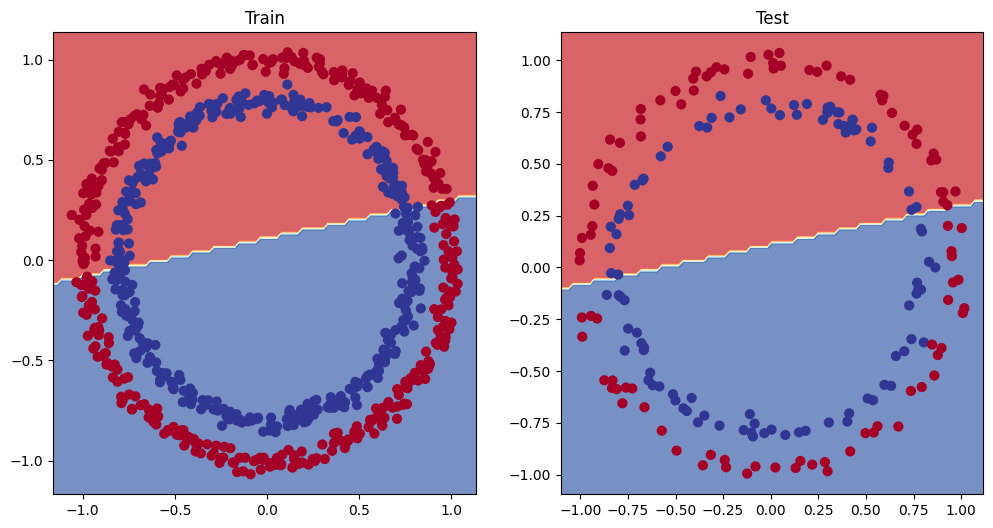

In [27]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Oh wow, it seems like we've found the cause of model's performance issue.

It's currently trying to split the red and blue dots using a straight line...

That explains the 50% accuracy. Since our data is circular, drawing a straight line can at best cut it down the middle.

In machine learning terms, our model is **underfitting**, meaning it's not learning predictive patterns from the data.

How could we improve this?

## 5. Improving a model (from a model perspective)

Let's try to fix our model's underfitting problem.

Focusing specifically on the model (not the data), there are a few ways we could do this.

| Model improvement technique* | What does it do? |
| ----- | ----- |
| **Add more layers** | Each layer *potentially* increases the learning capabilities of the model with each layer being able to learn some kind of new pattern in the data. More layers are often referred to as making your neural network *deeper*. |
| **Add more hidden units** | Similar to the above, more hidden units per layer means a *potential* increase in learning capabilities of the model. More hidden units are often referred to as making your neural network *wider*. |
| **Fitting for longer (more epochs)** | Your model might learn more if it had more opportunities to look at the data. |
| **Changing the activation functions** | Some data just can't be fit with only straight lines (like what we've seen), using non-linear activation functions can help with this (hint, hint). |
| **Change the learning rate** | Less model specific, but still related, the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough. |
| **Change the loss function** | Again, less model specific but still important, different problems require different loss functions. For example, a binary cross entropy loss function won't work with a multi-class classification problem. |
| **Use transfer learning** | Take a pretrained model from a problem domain similar to yours and adjust it to your own problem. We cover transfer learning in [notebook 06](https://www.learnpytorch.io/06_pytorch_transfer_learning/). |

> **Note:** *because you can adjust all of these by hand, they're referred to as **hyperparameters**.
>
> And this is also where machine learning's half art half science comes in, there's no real way to know here what the best combination of values is for your project, best to follow the data scientist's motto of "experiment, experiment, experiment".

Let's see what happens if we add an extra layer to our model, fit for longer (`epochs=1000` instead of `epochs=100`) and increase the number of hidden units from `5` to `10`.

We'll follow the same steps we did above but with a few changed hyperparameters.

In [28]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.

        z = self.layer_1(x)
        z = self.layer_2(z)
        z = self.layer_3(z)
        return z
        # return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

Now we've got a model, we'll recreate a loss function and optimizer instance, using the same settings as before.

In [29]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

Beautiful, model, optimizer and loss function ready, let's make a training loop.

This time we'll train for longer (`epochs=1000` vs `epochs=100`) and see if it improves our model.

In [30]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00%


In [31]:
### Testing
model_1.eval()
with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Caculate loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    print(f"Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Test loss: 0.69468, Test acc: 46.00%


What? Our model trained for longer and with an extra layer but it still looks like it didn't learn any patterns better than random guessing.

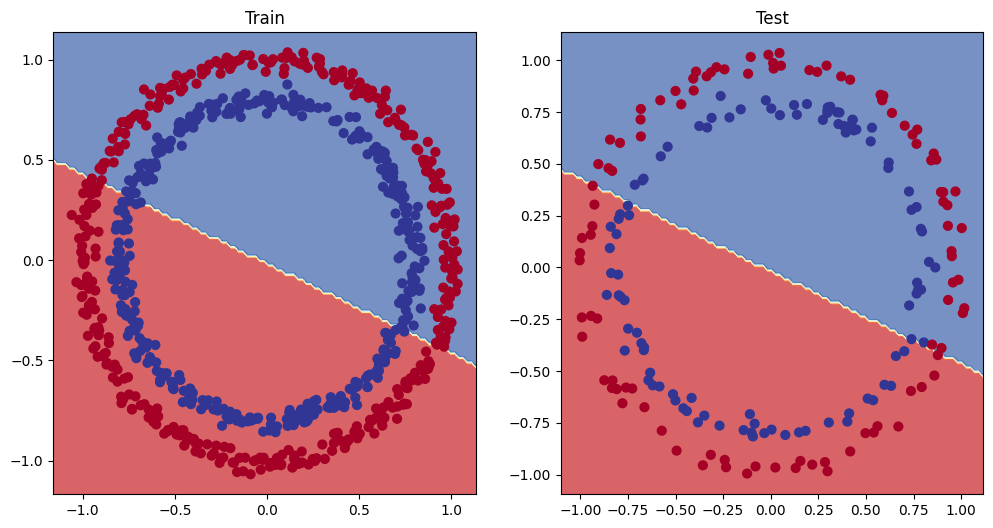

In [32]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 6. The missing piece: non-linearity

We've seen our model can draw straight (linear) lines, thanks to its linear layers.

But how about we give it the capacity to draw non-straight (non-linear)lines?


### 6.1 Building a model with non-linearity

I bet you could get pretty creative.

So far our neural networks have only been using linear (straight) line functions.

But the data we've been working with is non-linear (circles).

What do you think will happen when we introduce the capability for our model to use **non-linear activation functions**?

PyTorch has a bunch of [ready-made non-linear activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) that do similar but different things.

One of the most common and best performing is [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) (rectified linear-unit, [`torch.nn.ReLU()`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)).

Rather than talk about it, let's put it in our neural network between the hidden layers in the forward pass and see what happens.

In [33]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
      z = self.layer_1(x)
      z = self.relu(z)
      z = self.layer_2(z)
      z = self.relu(z)
      z = self.layer_3(z)

      return z
    #   return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


A rule of thumb is to put them in between hidden layers and just after the output layer, however, there is no set in stone option. As you learn more about neural networks and deep learning you'll find a bunch of different ways of putting things together. In the meantime, best to experiment, experiment, experiment.

### 6.2 Training a model with non-linearity

In [34]:
# Fit the model
torch.manual_seed(42)
epochs = 2500

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75%
Epoch: 1100 | Loss: 0.48153, Accuracy: 93.50%
Epoch: 1200 | Loss: 0.37056, Accuracy: 97.75%
Epoch: 1300 | Loss: 0.25458, Accuracy: 99.00%
Epoch: 1400 | Loss: 0.17180, Accuracy: 99.50%
Epoch: 1500 | Loss: 0.12188, Accuracy: 99.62%
Epoch: 1600 | Loss: 0.09123, Accuracy: 99.88%
Epoch: 1700 | Loss: 0.07100, Accuracy: 99.88%
Epoch: 1800 | Loss: 0.05773, Accuracy: 99.88%
Epoch: 1900 | Loss: 0.04853, Accuracy: 99.88%
Epoch: 2000 | Loss: 0.04176, Accuracy: 99.88%
Epoch: 2100 | Loss: 0.03628, Accuracy: 99.88%


In [35]:
### Testing
model_3.eval()
with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_3(X_test)
    print(test_logits.shape, test_logits[0], test_logits[0, 0])
    test_logits = test_logits.squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Caculate loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    print(f"Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

torch.Size([200, 1]) tensor([6.2458]) tensor(6.2458)
Test loss: 0.04366, Test acc: 100.00%


### 6.3 Evaluating a model trained with non-linear activation functions

Remember how our circle data is non-linear? Well, let's see how our models predictions look now the model's been trained with non-linear activation functions.

In [36]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test)).squeeze())
print(f"{y_preds[:10]}, {y_test[:10]}") # want preds in same format as truth labels

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]), tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


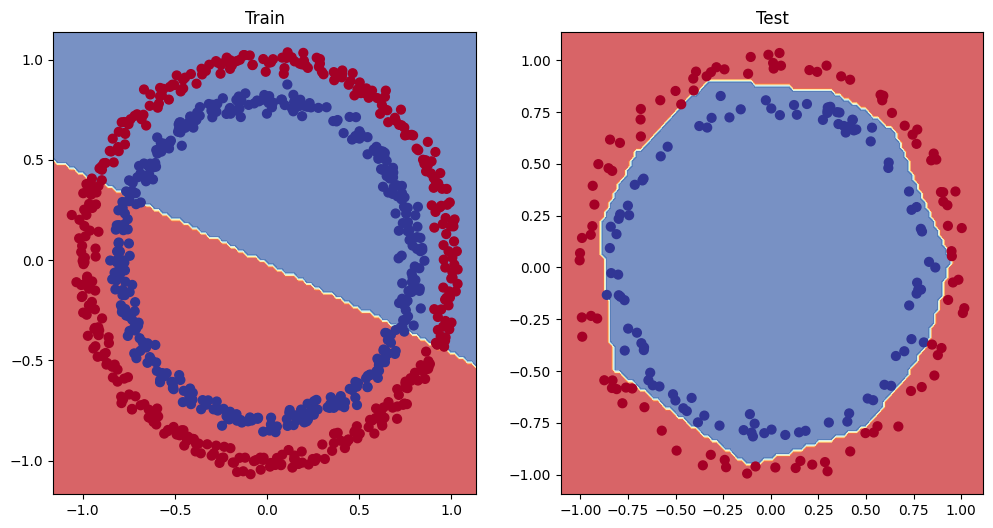

In [37]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

Nice! Not perfect but still far better than before.

Potentially you could try a few tricks to improve the test accuracy of the model? (hint: head back to section 5 for tips on improving the model)

## 7. Replicating non-linear activation functions

We saw before how adding non-linear activation functions to our model can help it to model non-linear data.

> **Note:** Much of the data you'll encounter in the wild is non-linear (or a combination of linear and non-linear). Right now we've been working with dots on a 2D plot. But imagine if you had images of plants you'd like to classify, there's a lot of different plant shapes. Or text from Wikipedia you'd like to summarize, there's lots of different ways words can be put together (linear and non-linear patterns).

But what does a non-linear activation *look* like?

How about we replicate some and what they do?

Let's start by creating a small amount of data.

In [38]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

Wonderful, now let's plot it.

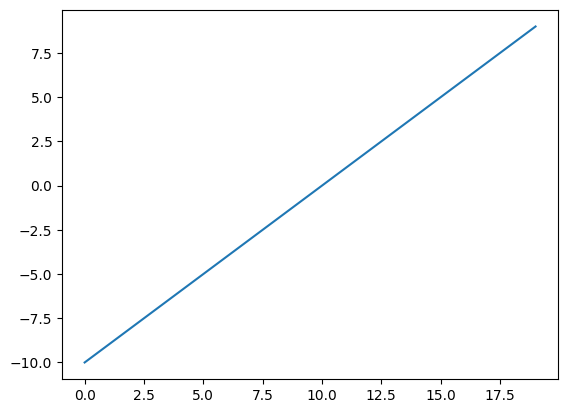

In [39]:
# Visualize the toy tensor
plt.plot(A);

A straight line, nice.

Now let's see how the ReLU activation function influences it.

And instead of using PyTorch's ReLU (`torch.nn.ReLU`), we'll recreate it ourselves.

The ReLU function turns all negatives to 0 and leaves the positive values as they are.

In [40]:
# Create ReLU function by hand
def relu(x):
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Pass toy tensor through ReLU function
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

It looks like our ReLU function worked, all of the negative values are zeros.

Let's plot them.

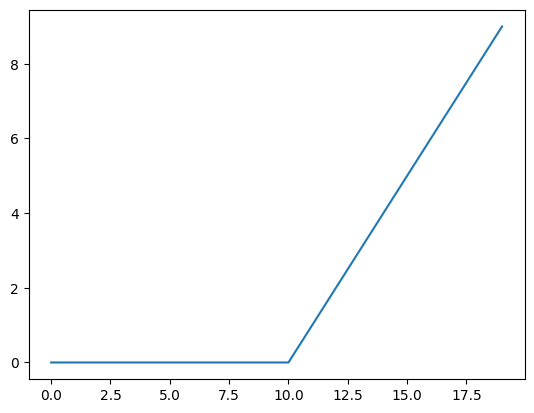

In [41]:
# Plot ReLU activated toy tensor
plt.plot(relu(A));

Nice! That looks exactly like the shape of the ReLU function on the [Wikipedia page for ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)).

How about we try the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) we've been using?

The sigmoid function formula goes like so:

$$ out_i = \frac{1}{1+e^{-input_i}} $$

Or using $x$ as input:

$$ S(x) = \frac{1}{1+e^{-x_i}} $$

Where $S$ stands for sigmoid, $e$ stands for [exponential](https://en.wikipedia.org/wiki/Exponential_function) ([`torch.exp()`](https://pytorch.org/docs/stable/generated/torch.exp.html)) and $i$ stands for a particular element in a tensor.

Let's build a function to replicate the sigmoid function with PyTorch.

In [42]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

Woah, those values look a lot like prediction probabilities we've seen earlier, let's see what they look like visualized.

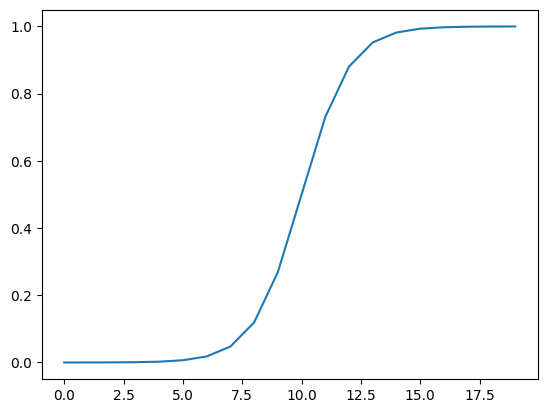

In [43]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A));

Looking good! We've gone from a straight line to a curved line.

Now there's plenty more [non-linear activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) that exist in PyTorch that we haven't tried.

But these two are two of the most common.

And the point remains, what patterns could you draw using an unlimited amount of linear (straight) and non-linear (not straight) lines? Almost anything right?

That's exactly what our model is doing when we combine linear and non-linear functions.

Instead of telling our model what to do, we give it tools to figure out how to best discover patterns in the data.

And those tools are linear and non-linear functions.

## Challenge


1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
    * For consistency, the dataset should have 1000 samples and a `random_state=42`.
    * Turn the data into PyTorch tensors. Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.
2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
    * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.
3. Setup a binary classification compatible loss function and optimizer to use when training the model.
4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
    * To measure model accuracy, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
    * Train the model for long enough for it to reach over 96% accuracy.
    * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.
5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [44]:
from sklearn.datasets import make_moons


# Create moons
X, y = make_moons(n_samples=1000,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [45]:
# Make DataFrame of moon data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
# circles.head(10)

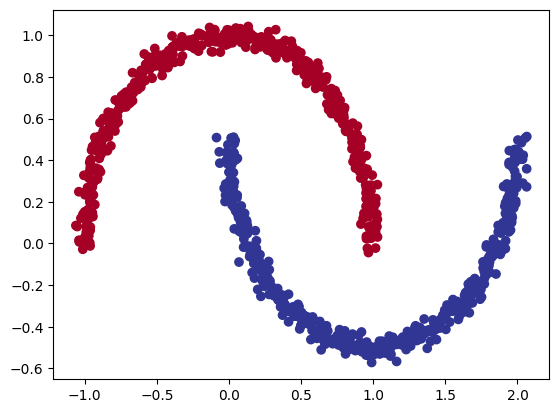

In [46]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [47]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X_tensor = torch.from_numpy(X).type(torch.float)
y_tensor = torch.from_numpy(y).type(torch.float)

# View the first five samples
X_tensor[:5], y_tensor[:5]

(tensor([[-0.0093,  0.3910],
         [ 0.9546, -0.4738],
         [ 0.9185, -0.4252],
         [ 0.4128, -0.3764],
         [-0.8453,  0.5288]]),
 tensor([1., 1., 1., 1., 0.]))

In [48]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor,
                                                    y_tensor,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [49]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"


# moon model
moon_model = nn.Sequential(
    nn.Linear(in_features=2, out_features=7),
    nn.ReLU(),
    nn.Linear(in_features=7, out_features=7),
    nn.ReLU(),
    nn.Linear(in_features=7, out_features=1),
).to(device)

# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(moon_model.parameters(), lr=0.1)

moon_model



Sequential(
  (0): Linear(in_features=2, out_features=7, bias=True)
  (1): ReLU()
  (2): Linear(in_features=7, out_features=7, bias=True)
  (3): ReLU()
  (4): Linear(in_features=7, out_features=1, bias=True)
)

In [50]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = moon_model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    moon_model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = moon_model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.73193, Accuracy: 50.00% | Test Loss: 0.72830, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.41257, Accuracy: 84.12% | Test Loss: 0.42374, Test Accuracy: 83.50%
Epoch: 200 | Loss: 0.25178, Accuracy: 88.25% | Test Loss: 0.25529, Test Accuracy: 89.50%
Epoch: 300 | Loss: 0.21978, Accuracy: 89.88% | Test Loss: 0.21588, Test Accuracy: 91.50%
Epoch: 400 | Loss: 0.19700, Accuracy: 90.88% | Test Loss: 0.19131, Test Accuracy: 92.50%
Epoch: 500 | Loss: 0.16306, Accuracy: 92.75% | Test Loss: 0.15685, Test Accuracy: 93.50%
Epoch: 600 | Loss: 0.11987, Accuracy: 95.00% | Test Loss: 0.11361, Test Accuracy: 97.00%
Epoch: 700 | Loss: 0.07900, Accuracy: 98.25% | Test Loss: 0.07336, Test Accuracy: 98.50%
Epoch: 800 | Loss: 0.05095, Accuracy: 99.38% | Test Loss: 0.04608, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.03429, Accuracy: 99.75% | Test Loss: 0.03011, Test Accuracy: 100.00%


In [51]:
# Make predictions
moon_model.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(moon_model(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

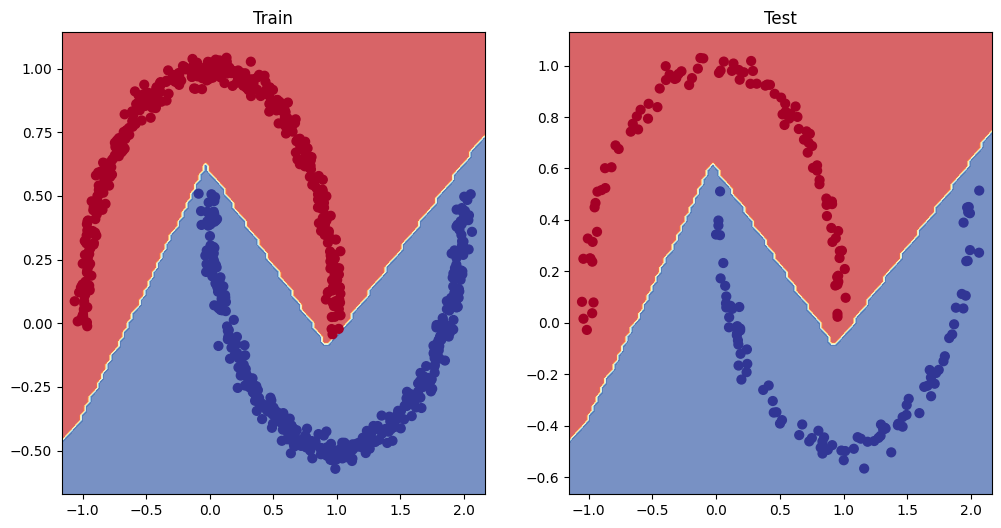

In [52]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(moon_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(moon_model, X_test, y_test)

## 8. Putting things together by building a multi-class PyTorch model

But now let's put it all together using a multi-class classification problem.

Recall a **binary classification** problem deals with classifying something as one of two options (e.g. a photo as a cat photo or a dog photo) where as a **multi-class classification** problem deals with classifying something from a list of *more than* two options (e.g. classifying a photo as a cat a dog or a chicken).

![binary vs multi-class classification image with the example of dog vs cat for binary classification and dog vs cat vs chicken for multi-class classification](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/02-binary-vs-multi-class-classification.png)
*Example of binary vs. multi-class classification. Binary deals with two classes (one thing or another), where as multi-class classification can deal with any number of classes over two, for example, the popular [ImageNet-1k dataset](https://www.image-net.org/) is used as a computer vision benchmark and has 1000 classes.*


### 8.1 Creating multi-class classification data

To begin a multi-class classification problem, let's create some multi-class data.

To do so, we can leverage Scikit-Learn's [`make_blobs()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) method.

This method will create however many classes (using the `centers` parameter) we want.

Specifically, let's do the following:

1. Create some multi-class data with `make_blobs()`.
2. Turn the data into tensors (the default of `make_blobs()` is to use NumPy arrays).
3. Split the data into training and test sets using `train_test_split()`.
4. Visualize the data.

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


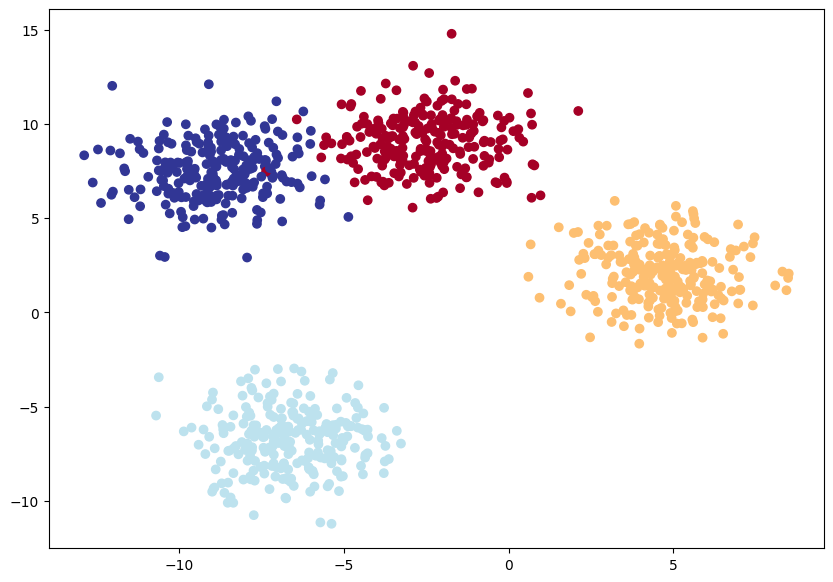

In [53]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

Nice! Looks like we've got some multi-class data ready to go.

Let's build a model to separate the coloured blobs.

> **Question:** Does this dataset need non-linearity? Or could you draw a succession of straight lines to separate it?

### 8.2 Building a multi-class classification model in PyTorch

We've created a few models in PyTorch so far.

You might also be starting to get an idea of how flexible neural networks are.

How about we build one similar to `model_3` but this is still capable of handling multi-class data?

To do so, let's create a subclass of `nn.Module` that takes in three hyperparameters:
* `input_features` - the number of `X` features coming into the model.
* `output_features` - the ideal numbers of output features we'd like (this will be equivalent to `NUM_CLASSES` or the number of classes in your multi-class classification problem).
* `hidden_units` - the number of hidden neurons we'd like each hidden layer to use.

Since we're putting things together, let's setup some device agnostic code (we don't have to do this again in the same notebook, it's only a reminder).

Then we'll create the model class using the hyperparameters above.

In [54]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [55]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
print(model_4)


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)


Excellent! Our multi-class model is ready to go, let's create a loss function and optimizer for it.

### 8.3 Creating a loss function and optimizer for a multi-class PyTorch model

Since we're working on a multi-class classification problem, we'll use the `nn.CrossEntropyLoss()` method as our loss function.

And we'll stick with using SGD with a learning rate of 0.1 for optimizing our `model_4` parameters.


In [56]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

So right now our model is outputing logits but what if we wanted to figure out exactly which label is was giving the sample?

As in, how do we go from `logits -> prediction probabilities -> prediction labels` just like we did with the binary classification problem?

That's where the [softmax activation function](https://en.wikipedia.org/wiki/Softmax_function) comes into play.

The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.

`torch.softmax`computes the soft‑max function along a specified axis of the input tensor.

The dim argument tells the function which dimension (axis) to treat as the “class” dimension – the values along that axis are exponentiated, summed, and then each element is divided by the sum.

* dim=0 → soft‑max is applied column‑wise (over the first dimension).
* dim=1 → soft‑max is applied row‑wise (over the second dimension).
* dim=2, dim=3, … → applied over deeper axes in higher‑dimensional tensors.

So in `torch.softmax(y_logits, dim=1)`, the soft‑max is computed for each row of y_logits, producing a probability distribution across the columns for each row.

In [57]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(f"Logits:\n{y_logits[:5]}")
print(f"Probabilities:\n{y_pred_probs[:5]}")

Logits:
tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], grad_fn=<SliceBackward0>)
Probabilities:
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], grad_fn=<SliceBackward0>)


After passing the logits through the softmax function, each individual sample now adds to 1 (or very close to).

In [58]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

These prediction probabilities are essentially saying how much the model *thinks* the target `X` sample (the input) maps to each class.

Since there's one value for each class in `y_pred_probs`, the index of the *highest* value is the class the model thinks the specific data sample *most* belongs to.

We can check which index has the highest value using `torch.argmax()`.

In [59]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], grad_fn=<SelectBackward0>)
tensor(3)


You can see the output of `torch.argmax()` returns 3, so for the features (`X`) of the sample at index 0, the model is predicting that the most likely class value (`y`) is 3.

Of course, right now this is just random guessing so it's got a 25% chance of being right (since there's four classes). But we can improve those chances by training the model.

> **Note:** For a multi-class classification problem, to turn the logits into **prediction probabilities**, you use the softmax activation function (`torch.softmax`).
>
> The index of the value with the highest **prediction probability** is the class number the model thinks is *most* likely given the input features for that sample (although this is a prediction, it doesn't mean it will be correct).

### 8.5 Creating a training and testing loop for a multi-class PyTorch model

Alright, now we've got all of the preparation steps out of the way, let's write a training and testing loop to improve and evaluate our model.

We've done many of these steps before so much of this will be practice.

The only difference is that we'll be adjusting the steps to turn the model outputs (logits) to prediction probabilities (using the softmax activation function) and then to prediction labels (by taking the argmax of the output of the softmax activation function).

Let's train the model for `epochs=100` and evaluate it every 10 epochs.

In [60]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}%")

Epoch: 0 | Loss: 1.04324, Acc: 65.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12%
Epoch: 20 | Loss: 0.08062, Acc: 99.12%
Epoch: 30 | Loss: 0.05924, Acc: 99.12%
Epoch: 40 | Loss: 0.04892, Acc: 99.00%
Epoch: 50 | Loss: 0.04295, Acc: 99.00%
Epoch: 60 | Loss: 0.03910, Acc: 99.00%
Epoch: 70 | Loss: 0.03643, Acc: 99.00%
Epoch: 80 | Loss: 0.03448, Acc: 99.00%
Epoch: 90 | Loss: 0.03300, Acc: 99.12%


In [61]:
### Testing
model_4.eval()
with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Calculate test loss and accuracy
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)
    print(f"Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Test Loss: 0.02304, Test Acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

It looks like our trained model is performing pretty well.

But to make sure of this, let's make some predictions and visualize them.

In [62]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
print(f"Logits: {y_logits[:10]}")

# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Logits: tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5310,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]])
Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


> **Note:** It's possible to skip the `torch.softmax()` function and go straight from `predicted logits -> predicted labels` by calling `torch.argmax()` directly on the logits.
>
> For example, `y_preds = torch.argmax(y_logits, dim=1)`, this saves a computation step (no `torch.softmax()`) but results in no prediction probabilities being available to use.

Nice! Our model predictions are now in the same form as our test labels.

Let's visualize them with `plot_decision_boundary()`, remember because our data is on the GPU, we'll have to move it to the CPU for use with matplotlib (`plot_decision_boundary()` does this automatically for us).

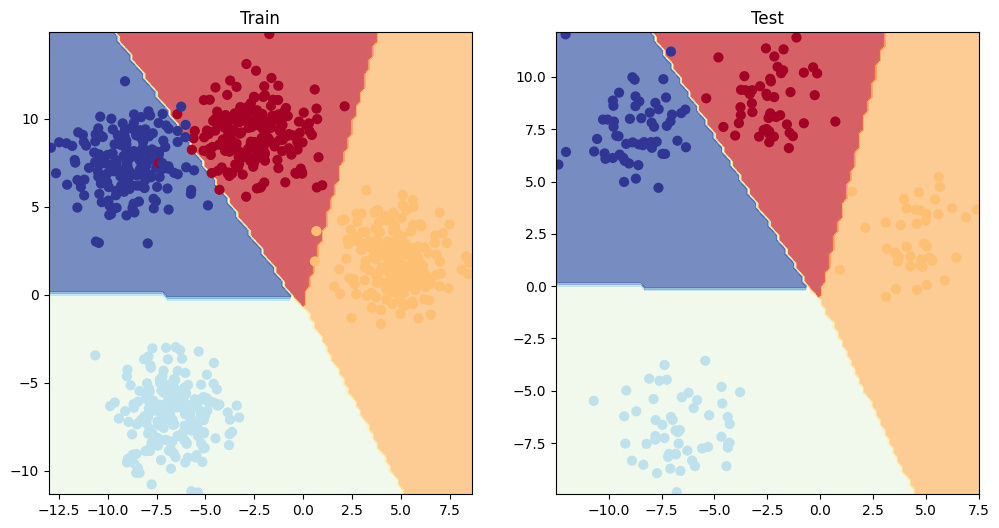

In [63]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. More classification evaluation metrics

So far we've only covered a couple of ways of evaluating a classification model (accuracy, loss and visualizing predictions).

These are some of the most common methods you'll come across and are a good starting point.

However, you may want to evaluate your classification model using more metrics such as the following:

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`torchmetrics.Accuracy()`](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html#id3) or [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`torchmetrics.Precision()`](https://torchmetrics.readthedocs.io/en/stable/classification/precision.html#id4) or [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`torchmetrics.Recall()`](https://torchmetrics.readthedocs.io/en/stable/classification/recall.html#id5) or [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`torchmetrics.F1Score()`](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html#f1score) or [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html#confusionmatrix) or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |

Scikit-Learn (a popular and world-class machine learning library) has many implementations of the above metrics and you're looking for a PyTorch-like version, check out [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/), especially the [TorchMetrics classification section](https://torchmetrics.readthedocs.io/en/stable/pages/classification.html).

Let's try the `torchmetrics.Accuracy` metric out.




In [64]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 6.0 MB/s eta 0:00:00


tensor(0.9950)

## Challenge

Create a multi-class dataset using the spirals data creation function found below.

* Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
* Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
* Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
* Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

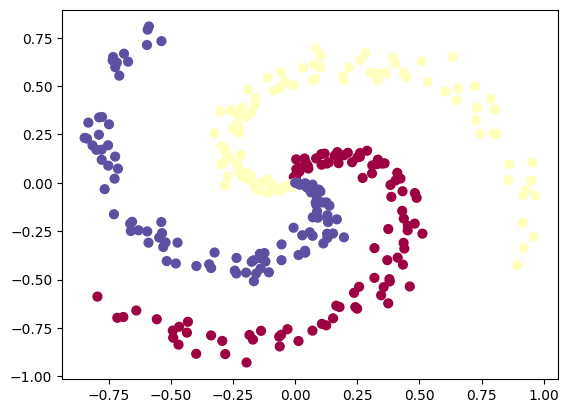

In [65]:
# Code for creating a spiral dataset
import numpy as np

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

## Init model

In [66]:
from torch import nn

# Build model
class SpiralMulticlassModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
spiral_model = SpiralMulticlassModel(input_features=2,
                    output_features=3,
                    hidden_units=15).to(device)
print(spiral_model)


# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(spiral_model.parameters(), lr=0.1)


SpiralMulticlassModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=15, bias=True)
    (5): ReLU()
    (6): Linear(in_features=15, out_features=3, bias=True)
  )
)


## Prepare the data

In [67]:
from sklearn.model_selection import train_test_split

# Put data to target device
X_spiral_train, X_spiral_test, y_spiral_train, y_spiral_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_spiral_train = torch.from_numpy(X_spiral_train).type(torch.float).to(device)
y_spiral_train = torch.from_numpy(y_spiral_train).type(torch.LongTensor).to(device)


X_spiral_test = torch.from_numpy(X_spiral_test).type(torch.float).to(device)
y_spiral_test = torch.from_numpy(y_spiral_test).type(torch.LongTensor).to(device)


X_spiral_train.shape, y_spiral_train.shape, X_spiral_test.shape, y_spiral_test.shape

(torch.Size([240, 2]),
 torch.Size([240]),
 torch.Size([60, 2]),
 torch.Size([60]))

In [68]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 1000



for epoch in range(epochs):
    ### Training
    spiral_model.train()

    # 1. Forward pass
    y_logits = spiral_model(X_spiral_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_spiral_train)
    acc = accuracy_fn(y_true=y_spiral_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}%")

Epoch: 0 | Loss: 1.09599, Acc: 35.00%
Epoch: 100 | Loss: 0.99810, Acc: 60.00%
Epoch: 200 | Loss: 0.74204, Acc: 55.42%
Epoch: 300 | Loss: 0.61816, Acc: 62.08%
Epoch: 400 | Loss: 0.47490, Acc: 74.17%
Epoch: 500 | Loss: 0.30516, Acc: 85.42%
Epoch: 600 | Loss: 0.21980, Acc: 91.67%
Epoch: 700 | Loss: 0.19291, Acc: 92.92%
Epoch: 800 | Loss: 0.11093, Acc: 95.83%
Epoch: 900 | Loss: 0.08862, Acc: 97.08%


## Test model

In [69]:
spiral_model.eval()
with torch.inference_mode():
    # 1. Forward pass
    test_logits = spiral_model(X_spiral_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Calculate test loss and accuracy
    test_loss = loss_fn(test_logits, y_spiral_test)
    test_acc = accuracy_fn(y_true=y_spiral_test, y_pred=test_pred)
    print(f"Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Test Loss: 0.04598, Test Acc: 98.33%


## Visualize predictions

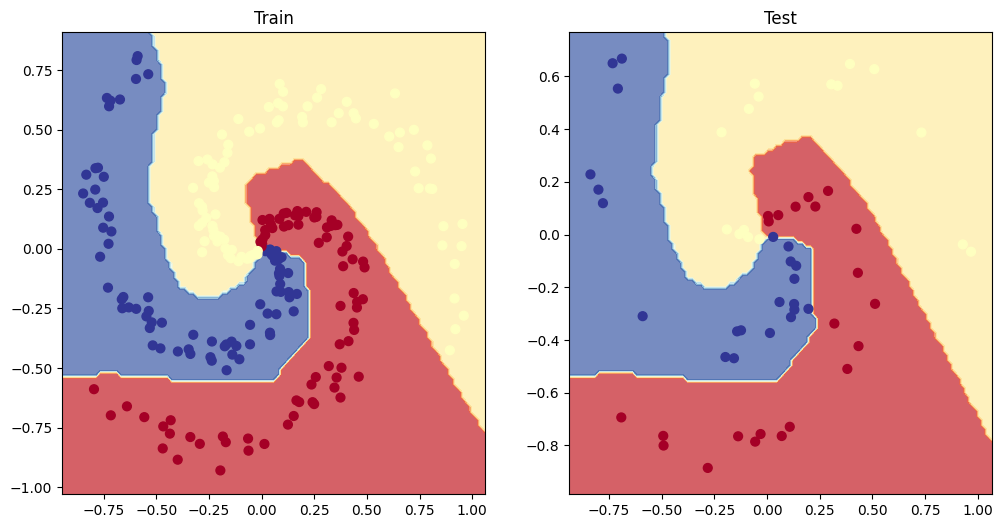

In [70]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(spiral_model, X_spiral_train, y_spiral_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(spiral_model, X_spiral_test, y_spiral_test)